# Predicción del riesgo de enfermedad cardíaca: Tarea de regresión logística

## Contexto introductorio
Las enfermedades cardíacas son la principal causa de muerte en el mundo, cobrándose aproximadamente 18 millones de vidas al año, según la Organización Mundial de la Salud. Modelos predictivos como la regresión logística permiten la identificación temprana de pacientes en riesgo mediante el análisis de características clínicas como la edad, el colesterol y la presión arterial. Esto no solo mejora los resultados del tratamiento, sino que también optimiza la asignación de recursos en los entornos sanitarios. En esta tarea, implementarás la regresión logística en el conjunto de datos de enfermedades cardíacas: una colección de repositorios UCI del mundo real con 303 registros de pacientes, 14 características y un objetivo binario (1 para presencia de enfermedad, 0 para ausencia). Entrenarás modelos, visualizarás límites, aplicarás regularización y explorarás la implementación mediante Amazon SageMaker para simular un pipeline de producción.

Importar librerias

In [1]:
%pip install numpy matplotlib pandas scikit-learn

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

Cargar y preparar el conjunto de datos

In [3]:

# Cargar el archivo CSV
df = pd.read_csv("Heart_Disease_Prediction.csv")

# Ver las primeras filas del dataset
print("Primeras 5 filas del dataset:")
print(df.head())
print("\n" + "="*80 + "\n")

# Información sobre el dataset
print("Información del dataset:")
print(df.info())
print("\n" + "="*80 + "\n")

# Estadísticas descriptivas
print("Estadísticas descriptivas:")
print(df.describe())
print("\n" + "="*80 + "\n")

# Ver la columna de destino
print("Valores únicos en 'Heart Disease':")
print(df['Heart Disease'].value_counts())
print("\n" + "="*80 + "\n")

# Binarizar la columna de destino: 1 = Presence (enfermedad), 0 = Absence (sin enfermedad)
df['Heart Disease'] = (df['Heart Disease'] == 'Presence').astype(int)

print("Después de binarizar:")
print(df['Heart Disease'].value_counts())
print("\nPrimeras filas después de binarizar:")
print(df.head())

Primeras 5 filas del dataset:
   Age  Sex  Chest pain type   BP  Cholesterol  FBS over 120  EKG results  \
0   70    1                4  130          322             0            2   
1   67    0                3  115          564             0            2   
2   57    1                2  124          261             0            0   
3   64    1                4  128          263             0            0   
4   74    0                2  120          269             0            2   

   Max HR  Exercise angina  ST depression  Slope of ST  \
0     109                0            2.4            2   
1     160                0            1.6            2   
2     141                0            0.3            1   
3     105                1            0.2            2   
4     121                1            0.2            1   

   Number of vessels fluro  Thallium Heart Disease  
0                        3         3      Presence  
1                        0         7       Absence  


6. ANÁLISIS DE CORRELACIONES

Correlación de características con 'Heart Disease':
Heart Disease              1.000000
Thallium                   0.525020
Number of vessels fluro    0.455336
Exercise angina            0.419303
ST depression              0.417967
Chest pain type            0.417436
Slope of ST                0.337616
Sex                        0.297721
Age                        0.212322
EKG results                0.182091
BP                         0.155383
Cholesterol                0.118021
FBS over 120              -0.016319
Max HR                    -0.418514
Name: Heart Disease, dtype: float64


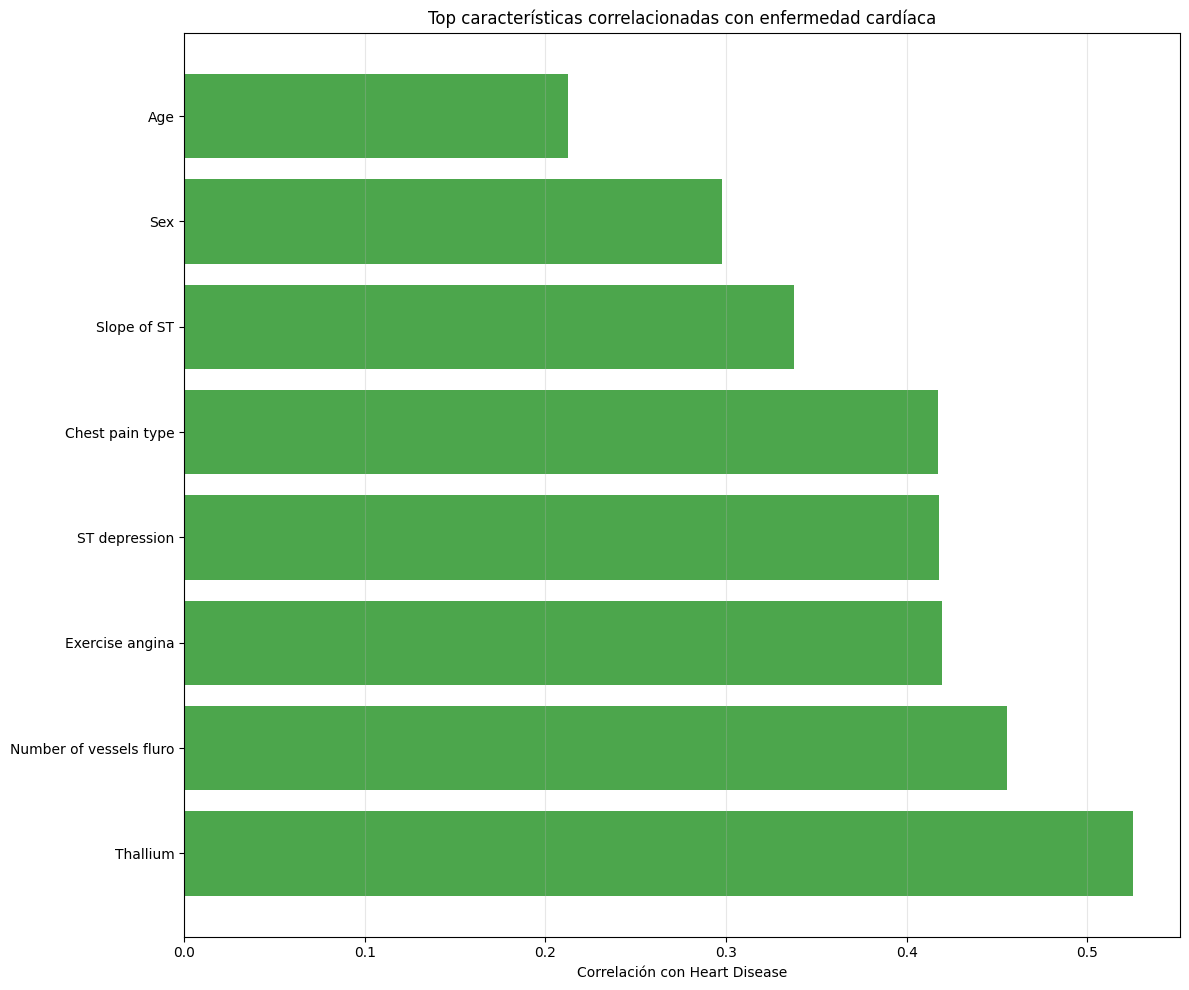


✓ Análisis de correlaciones completado.


In [10]:
# 6. CORRELACIONES Y MATRIZ DE CORRELACIÓN
print("\n" + "=" * 80)
print("6. ANÁLISIS DE CORRELACIONES")
print("=" * 80)

# Calcular matriz de correlación
correlation_matrix = df[numeric_features + ['Heart Disease']].corr()

# Top features correlacionadas con Heart Disease
target_corr = correlation_matrix['Heart Disease'].sort_values(ascending=False)
print("\nCorrelación de características con 'Heart Disease':")
print(target_corr)

# Visualizar matriz de correlación
plt.figure(figsize=(12, 10))
import matplotlib.pyplot as plt

# Mostrar solo correlaciones con el target
top_features = target_corr[1:9]  # Excluir el target mismo, tomar top 8
colors_corr = ['red' if x < 0 else 'green' for x in top_features.values]
plt.barh(range(len(top_features)), top_features.values, color=colors_corr, alpha=0.7)
plt.yticks(range(len(top_features)), top_features.index)
plt.xlabel('Correlación con Heart Disease')
plt.title('Top características correlacionadas con enfermedad cardíaca')
plt.axvline(x=0, color='black', linestyle='-', linewidth=0.5)
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

print("\n✓ Análisis de correlaciones completado.")



5. DISTRIBUCIÓN DE CARACTERÍSTICAS


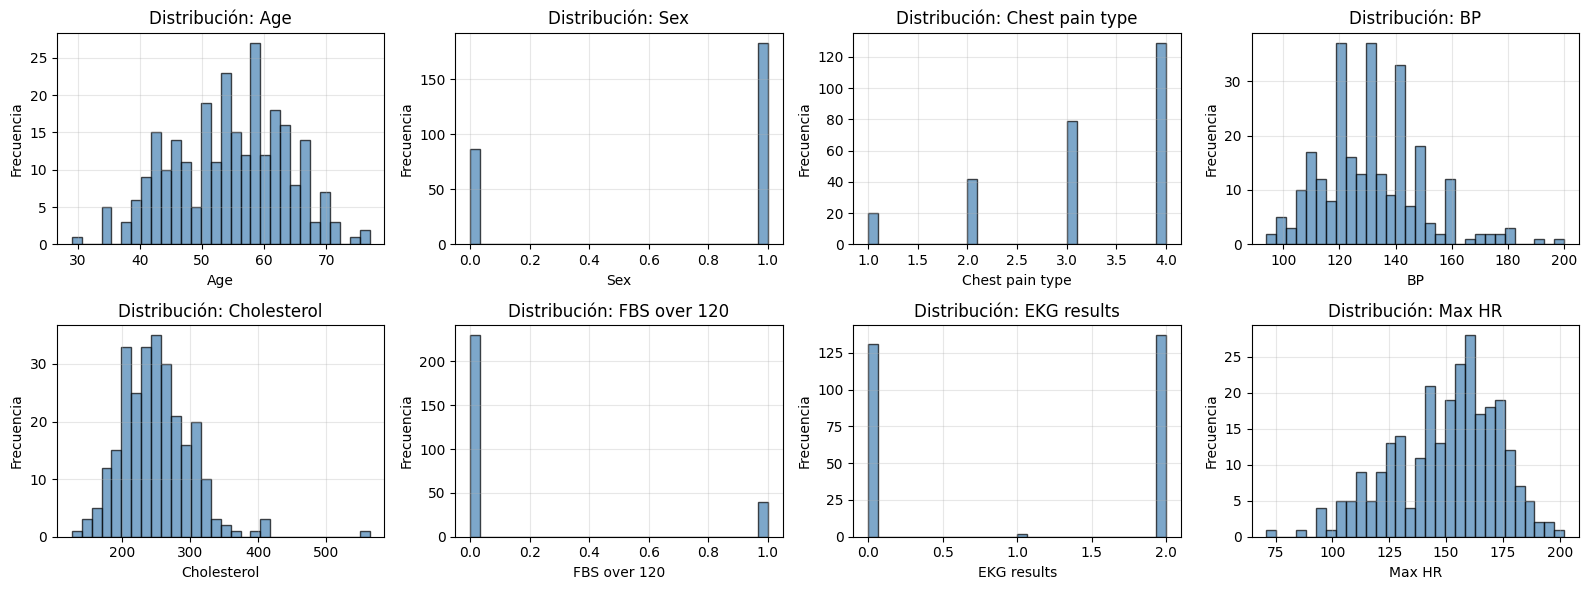


✓ Visualización de 8 características completada.


In [5]:
# 5. VISUALIZACIÓN DE DISTRIBUCIONES POR CARACTERÍSTICA
print("\n" + "=" * 80)
print("5. DISTRIBUCIÓN DE CARACTERÍSTICAS")
print("=" * 80)

# Seleccionar algunas características clave para visualizar
numeric_features = df.select_dtypes(include=[np.number]).columns.tolist()
if 'Heart Disease' in numeric_features:
    numeric_features.remove('Heart Disease')

# Visualizar histogramas y boxplots para primeras 8 características
features_to_plot = numeric_features[:min(8, len(numeric_features))]
n_features = len(features_to_plot)
n_cols = 4
n_rows = (n_features + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, n_rows*3))
axes = axes.flatten()

for idx, feature in enumerate(features_to_plot):
    axes[idx].hist(df[feature], bins=30, color='steelblue', alpha=0.7, edgecolor='black')
    axes[idx].set_title(f'Distribución: {feature}')
    axes[idx].set_xlabel(feature)
    axes[idx].set_ylabel('Frecuencia')
    axes[idx].grid(alpha=0.3)

# Ocultar ejes sobrantes
for idx in range(n_features, len(axes)):
    axes[idx].axis('off')

plt.tight_layout()
plt.show()

print(f"\n✓ Visualización de {len(features_to_plot)} características completada.")


In [6]:
# 4. ESTADÍSTICAS POR CLASE
print("\n" + "=" * 80)
print("4. ESTADÍSTICAS POR CLASE")
print("=" * 80)

print("\nEstadísticas para pacientes SIN enfermedad (clase 0):")
print(df[df['Heart Disease'] == 0].describe())

print("\n" + "-" * 80 + "\n")
print("Estadísticas para pacientes CON enfermedad (clase 1):")
print(df[df['Heart Disease'] == 1].describe())



4. ESTADÍSTICAS POR CLASE

Estadísticas para pacientes SIN enfermedad (clase 0):
              Age         Sex  Chest pain type          BP  Cholesterol  \
count  150.000000  150.000000       150.000000  150.000000   150.000000   
mean    52.706667    0.553333         2.820000  128.866667   244.213333   
std      9.509830    0.498813         0.927362   16.457660    54.019085   
min     29.000000    0.000000         1.000000   94.000000   126.000000   
25%     45.000000    0.000000         2.000000  120.000000   209.000000   
50%     52.000000    1.000000         3.000000  130.000000   236.000000   
75%     59.000000    1.000000         3.750000  140.000000   268.750000   
max     76.000000    1.000000         4.000000  180.000000   564.000000   

       FBS over 120  EKG results      Max HR  Exercise angina  ST depression  \
count    150.000000   150.000000  150.000000       150.000000     150.000000   
mean       0.153333     0.860000  158.333333         0.153333       0.622667   
st


3. DISTRIBUCIÓN DE CLASES (VARIABLE OBJETIVO)

Recuento de clases:
  Clase 0 (Sin enfermedad): 150 muestras (55.56%)
  Clase 1 (Presencia de enfermedad): 120 muestras (44.44%)

Ratio de clases (mayoritaria/minoritaria): 1.25
✓ Dataset relativamente equilibrado.


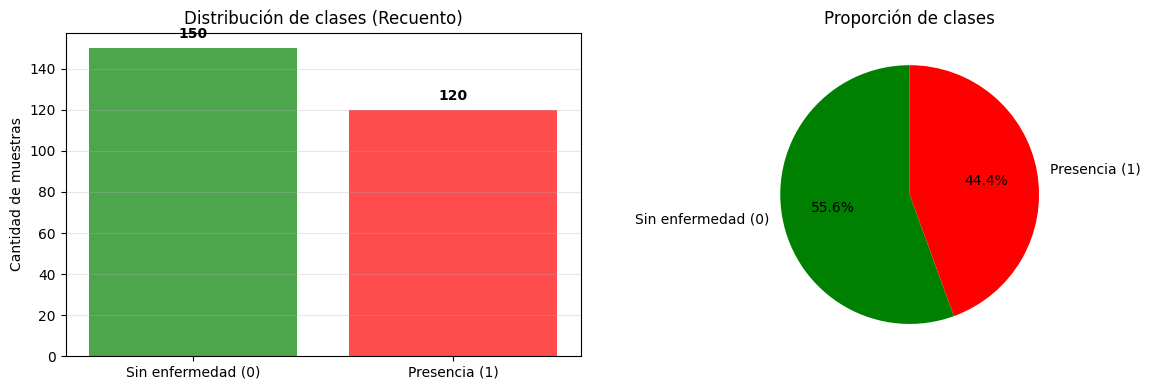


✓ Visualización de distribución completada.


In [7]:
# 3. DISTRIBUCIÓN DE CLASES (TARGET)
print("\n" + "=" * 80)
print("3. DISTRIBUCIÓN DE CLASES (VARIABLE OBJETIVO)")
print("=" * 80)

class_counts = df['Heart Disease'].value_counts()
class_proportions = df['Heart Disease'].value_counts(normalize=True) * 100

print("\nRecuento de clases:")
for idx in sorted(df['Heart Disease'].unique()):
    label = "Presencia de enfermedad" if idx == 1 else "Sin enfermedad"
    count = class_counts[idx]
    percentage = class_proportions[idx]
    print(f"  Clase {idx} ({label}): {count} muestras ({percentage:.2f}%)")

# Verificar balance de clases
class_ratio = class_counts.max() / class_counts.min()
print(f"\nRatio de clases (mayoritaria/minoritaria): {class_ratio:.2f}")

if abs(class_proportions[0] - class_proportions[1]) > 20:
    print("⚠ ADVERTENCIA: Dataset DESBALANCEADO. Considerar técnicas de balanceo.")
else:
    print("✓ Dataset relativamente equilibrado.")

# Visualizar distribución de clases
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Gráfico de barras
class_labels = ["Sin enfermedad (0)", "Presencia (1)"]
axes[0].bar(class_labels, class_counts.values, color=['green', 'red'], alpha=0.7)
axes[0].set_ylabel('Cantidad de muestras')
axes[0].set_title('Distribución de clases (Recuento)')
axes[0].grid(axis='y', alpha=0.3)
for i, v in enumerate(class_counts.values):
    axes[0].text(i, v + 5, str(v), ha='center', fontweight='bold')

# Gráfico de pastel
colors = ['green', 'red']
axes[1].pie(class_counts.values, labels=class_labels, autopct='%1.1f%%', 
            colors=colors, startangle=90)
axes[1].set_title('Proporción de clases')

plt.tight_layout()
plt.show()

print("\n✓ Visualización de distribución completada.")


In [8]:
# 2. ANÁLISIS DE VALORES ATÍPICOS (OUTLIERS)
print("\n" + "=" * 80)
print("2. ANÁLISIS DE VALORES ATÍPICOS (OUTLIERS)")
print("=" * 80)

# Identificar características numéricas
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
# Excluir la columna target
if 'Heart Disease' in numeric_cols:
    numeric_cols.remove('Heart Disease')

print(f"\nCaracterísticas numéricas analizadas: {len(numeric_cols)}")

# Detección de outliers usando IQR (Rango Intercuartílico)
outlier_summary = {}
for col in numeric_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
    if len(outliers) > 0:
        outlier_summary[col] = len(outliers)

if outlier_summary:
    print(f"\nSe encontraron valores atípicos en {len(outlier_summary)} columnas:")
    for col, count in sorted(outlier_summary.items(), key=lambda x: x[1], reverse=True):
        print(f"  - {col}: {count} outliers")
else:
    print("\n✓ No se detectaron valores atípicos significativos en las características.")

# Mostrar resumen de outliers como porcentaje
total_rows = len(df)
print("\nPorcentaje de outliers por columna:")
for col in numeric_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outlier_count = len(df[(df[col] < lower_bound) | (df[col] > upper_bound)])
    percentage = (outlier_count / total_rows) * 100
    if percentage > 0:
        print(f"  {col}: {percentage:.2f}%")



2. ANÁLISIS DE VALORES ATÍPICOS (OUTLIERS)

Características numéricas analizadas: 13

Se encontraron valores atípicos en 7 columnas:
  - FBS over 120: 40 outliers
  - Chest pain type: 20 outliers
  - Number of vessels fluro: 19 outliers
  - BP: 9 outliers
  - Cholesterol: 5 outliers
  - ST depression: 4 outliers
  - Max HR: 1 outliers

Porcentaje de outliers por columna:
  Chest pain type: 7.41%
  BP: 3.33%
  Cholesterol: 1.85%
  FBS over 120: 14.81%
  Max HR: 0.37%
  ST depression: 1.48%
  Number of vessels fluro: 7.04%


In [9]:
# 1. VERIFICAR DATOS FALTANTES
print("=" * 80)
print("1. ANÁLISIS DE DATOS FALTANTES")
print("=" * 80)
missing_data = df.isnull().sum()
print("\nDatos faltantes por columna:")
print(missing_data)
print(f"\nTotal de datos faltantes en el dataset: {missing_data.sum()}")

if missing_data.sum() == 0:
    print("✓ ¡Excelente! No hay datos faltantes en el dataset.")
else:
    print("\nColumnas con datos faltantes:")
    print(missing_data[missing_data > 0])
    # Opción: rellenar con la media para numéricas
    df = df.fillna(df.mean(numeric_only=True))
    print("Datos faltantes rellenados con la media.")


1. ANÁLISIS DE DATOS FALTANTES

Datos faltantes por columna:
Age                        0
Sex                        0
Chest pain type            0
BP                         0
Cholesterol                0
FBS over 120               0
EKG results                0
Max HR                     0
Exercise angina            0
ST depression              0
Slope of ST                0
Number of vessels fluro    0
Thallium                   0
Heart Disease              0
dtype: int64

Total de datos faltantes en el dataset: 0
✓ ¡Excelente! No hay datos faltantes en el dataset.


## Análisis Exploratorio de Datos (EDA)